참고 자료 1 : https://www.youtube.com/watch?v=o25jAgm63X0

In [7]:
from dotenv import load_dotenv
import os

In [8]:
# .env 파일 로드(api key load)
load_dotenv()

True

In [9]:
#langsmith Setting
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com" 
os.environ["LANGCHAIN_PROJECT"] = "langsmith_basic"                 #표시될 PJT명 Setting
#os.environ["LANGCHAIN_API_KEY"] = "lsv2_***"                        *.env로 setting
from langsmith import Client
client = Client()

1. library import 하기

In [15]:
from typing_extensions import TypedDict 
#typing이나 typing_extensions나 동일하게 동작하나 langgraph 공식 문서에서는 typing_extensions에서 갖고 온다
from typing import Annotated

from langgraph.graph import StateGraph, START, END
import operator


2. StateGpraph로 State 만들기
- node간 전달할 때 전달되는 인자들 선언하기

In [16]:
class State(TypedDict):       #State에 TypeDict 상속해서 사용
    counter: int              #counter 인자는 int 속성
    alphabet: list[str]       #alphabet 인자는 list 속성이면서 그 안의 인자는 str

graph_builder = StateGraph(State) #StateGraph 객체 선언하기

3. node 함수 만들기
- state값을 입력받고 return값을 지정하기 된다.

In [18]:
def node_a(state: State):      #state로 State의 객체를 선언한다.
    state['counter'] += 1          #counter에 1을 더한다.
    state['alphabet'] = ['Hello']  #alphabet에 Hello로 지정한다.
    return state

4. langgaph에 node 및 edge 설정하기

In [20]:
graph_builder.add_node('chatbot', node_a) # chatbot이름의 노드를 만들고 노드 함수는 node_a 사용

graph_builder.add_edge(START,'chatbot')  # START -> chatbot edge 만들기
graph_builder.add_edge('chatbot',END)    # chatbot -> END edge 만들기

5. langgraph를 컴파일하기

In [21]:
graph = graph_builder.compile()          #

6. langhgraph 시각화로 확인하기

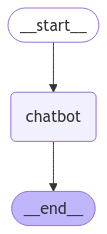

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print('langgraph가 만들어지지 않았습니다.')
    pass

7. 초기값 설정 후 실행하기

In [24]:
# 초기 상태 정의
intial_state = {
    'counter' : 0,
    'alphabet' : ['a']
}

In [ ]:
state_act = intial_state
for _ in range(3):                       #3회 실시하기
    state_act = graph.invoke(state_act)
    print(state_act)


{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello']}
{'counter': 3, 'alphabet': ['Hello']}


### Annotate를 이용해서 list 내용 계속 추가하기

In [70]:
class State2(TypedDict):       #State에 TypeDict 상속해서 사용
    counter: int              #counter 인자는 int 속성
    alphabet: Annotated[list[str], operator.add] #Annotated + operator.add로 list 추가하기

graph_builder2 = StateGraph(State2) #StateGraph 객체 선언하기

In [71]:
def node_a2(state: State2):      #state로 State의 객체를 선언한다.
    state['counter'] += 1          #counter에 1을 더한다.
    state['alphabet'] = ['Hello']  #alphabet에 Hello로 지정한다.
    return state

In [72]:
graph_builder2.add_node('chatbot', node_a2) # chatbot이름의 노드를 만들고 노드 함수는 node_a 사용

graph_builder2.add_edge(START,'chatbot')  # START -> chatbot edge 만들기
graph_builder2.add_edge('chatbot',END)    # chatbot -> END edge 만들기

In [73]:
graph2 = graph_builder2.compile()   

In [74]:
# 초기 상태 정의
intial_state = {
    'counter' : 0,
    'alphabet' : ['a']
}

In [75]:
state_act2 = intial_state
for _ in range(3):                       #3회 실시하기
    state_act2 = graph2.invoke(state_act2)
    print(state_act2)

{'counter': 1, 'alphabet': ['a', 'Hello']}
{'counter': 2, 'alphabet': ['a', 'Hello', 'Hello']}
{'counter': 3, 'alphabet': ['a', 'Hello', 'Hello', 'Hello']}


### Message를 담은 StateGraph 만들기

In [6]:
from typing_extensions import TypedDict 
#typing이나 typing_extensions나 동일하게 동작하나 langgraph 공식 문서에서는 typing_extensions에서 갖고 온다
from typing import Annotated

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import operator

from langchain_google_genai import ChatGoogleGenerativeAI

from dotenv import load_dotenv
import os

In [2]:
# .env 파일 로드(api key load)
load_dotenv()

True

In [28]:
#langsmith Setting
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com" 
os.environ["LANGCHAIN_PROJECT"] = "langsmith_basic"                 #표시될 PJT명 Setting
#os.environ["LANGCHAIN_API_KEY"] = "lsv2_***"                        *.env로 setting
from langsmith import Client
client = Client()

In [27]:
class State3(TypedDict):
    messages : Annotated[list,add_messages] #add_messages의 메타 data를 갖는 list 형태의 message dict 만들기

graph_builder3 = StateGraph(State3)

In [29]:
llm = ChatGoogleGenerativeAI(model='gemini-1.5-pro', temperature= 0)

In [30]:
def chatbot(state: State3):                             #State3(typedict)를 입력받아 내부 변수인 state로 만든다.
    return {"messages" : llm.invoke(state['messages'])} #state(typedict)의 'messages' key값을 llm에 invoke한다.

In [31]:
graph_builder3.add_node('chatbot_new', chatbot) # chatbot_new 이름의 노드를 만들고 노드 함수는 chatbot 사용

graph_builder3.set_entry_point('chatbot_new') #graph에서 start지점 설정하기
graph_builder3.set_finish_point('chatbot_new') #graph에서 finish지점 설정하기기

In [32]:
graph3 = graph_builder3.compile() #graph3로 compilie하기

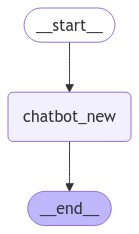

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph3.get_graph().draw_mermaid_png()))
except Exception:
    print('langgraph가 만들어지지 않았습니다.')
    pass

In [48]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ['quit','exit','q']:
        print('Good bye')
        break
    else:
        for event in graph3.stream({'messages': ('user',user_input)}):
            print(event['chatbot_new']['messages'].content)

안녕하세요! 무엇을 도와드릴까요?

저는 Google에서 훈련한 대규모 언어 모델입니다.
Gemini API는 Google에서 개발한 대규모 언어 모델(LLM)에 접근할 수 있는 인터페이스입니다. 텍스트 생성, 번역, 다양한 종류의 창의적인 콘텐츠 작성, 정보 제공 방식으로 질문에 답변하는 등 다양한 작업을 수행할 수 있습니다.  다음은 Gemini API의 주요 특징과 기능에 대한 설명입니다.

**주요 기능:**

* **텍스트 생성:** 이야기, 기사, 요약, 이메일 등 다양한 형태의 텍스트를 생성할 수 있습니다. 창의적인 글쓰기, 코드 생성, 번역, 비즈니스 문서 작성 등 다양한 용도로 활용 가능합니다.
* **코드 생성 및 편집:**  Gemini API는 Python, Java, Javascript, C++ 등 다양한 프로그래밍 언어로 코드를 생성하고 편집할 수 있습니다.  주어진 요구사항에 맞는 코드를 생성하거나, 기존 코드를 디버깅하고 최적화하는 데 도움을 줄 수 있습니다.
* **다양한 자연어 작업:** 텍스트 분류, 감정 분석, 개체명 인식, 질의응답 등 다양한 자연어 처리 작업을 수행할 수 있습니다.
* **다국어 지원:** 다양한 언어를 이해하고 생성할 수 있어, 번역 및 다국어 콘텐츠 생성에 유용합니다.
* **미세 조정 (Fine-tuning):** 특정 작업이나 도메인에 맞게 모델을 미세 조정하여 성능을 향상시킬 수 있습니다.  자체 데이터를 사용하여 모델을 학습시켜 특정 요구사항에 맞는 결과를 얻을 수 있습니다.
* **다양한 모델 크기:**  다양한 크기의 모델을 제공하여 필요에 따라 성능과 효율성을 선택할 수 있습니다.  작은 모델은 빠른 응답 시간이 필요한 작업에 적합하며, 큰 모델은 더 복잡하고 정확한 결과가 필요한 작업에 적합합니다.


**Gemini API 사용 방법:**

Gemini API는 REST API 형태로 제공되며, 다양한 프로그래밍 언어에서 사용할 수 있습니다.  Google Cloud Platform 콘

In [49]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ['quit','exit','q']:
        print('Good bye')
        break
    else:
        for event in graph3.stream({'messages': ('user',user_input)}):
            print(f"User Message : {user_input}")
            print(f"Assistant : {event['chatbot_new']['messages'].content}")

User Message : 안녕
Assistant : 안녕하세요! 무엇을 도와드릴까요?

User Message : 안녕
Assistant : 안녕하세요! 무엇을 도와드릴까요?

User Message : gemini api 사용방법에 대해서 설명해 줘
Assistant : Gemini API 사용 방법에 대해 설명드리겠습니다. Gemini API는 Google에서 개발한 대규모 언어 모델입니다. 이 API를 사용하면 텍스트 생성, 번역, 다양한 종류의 창의적인 콘텐츠 작성, 정보 질문에 대한 포괄적이고 유익한 답변을 얻을 수 있습니다.

**1. Google Cloud 프로젝트 설정 및 API 활성화:**

* Google Cloud Platform(GCP) 계정이 없다면 생성합니다. (https://cloud.google.com/)
* GCP 콘솔에서 새 프로젝트를 만들거나 기존 프로젝트를 사용합니다.
* 프로젝트에서 Gemini API를 활성화합니다.  GCP 콘솔의 검색창에서 "Vertex AI API"를 검색하고 활성화합니다. Gemini API는 Vertex AI의 일부입니다.
* 필요한 경우 결제 정보를 설정합니다. Gemini API 사용량에 따라 요금이 부과될 수 있습니다.

**2. API 키 생성:**

* GCP 콘솔에서 "API 및 서비스" > "사용자 인증 정보"로 이동합니다.
* "사용자 인증 정보 만들기"를 클릭하고 "API 키"를 선택합니다.
* 생성된 API 키를 안전하게 저장합니다.  이 키는 API에 접근하는 데 필요한 중요한 정보입니다.

**3. 클라이언트 라이브러리 설치 (선택적, 권장):**

* Google에서 제공하는 Python 클라이언트 라이브러리를 사용하면 API 호출을 더 쉽게 할 수 있습니다.
* `pip install google-cloud-aiplatform` 명령어를 사용하여 라이브러리를 설치합니다.  다른 언어에 대한 라이브러리도 제공됩니다.

**4. API 호출:**

API를 호출하는 방법은 

### MessageState 활용하기

In [50]:
from typing_extensions import TypedDict 
#typing이나 typing_extensions나 동일하게 동작하나 langgraph 공식 문서에서는 typing_extensions에서 갖고 온다
from typing import Annotated

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
import operator

from langchain_google_genai import ChatGoogleGenerativeAI

from dotenv import load_dotenv
import os

In [51]:
# .env 파일 로드(api key load)
load_dotenv()

True

In [52]:
#langsmith Setting
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com" 
os.environ["LANGCHAIN_PROJECT"] = "langsmith_basic"                 #표시될 PJT명 Setting
#os.environ["LANGCHAIN_API_KEY"] = "lsv2_***"                        *.env로 setting
from langsmith import Client
client = Client()

In [53]:
#add_messages의 메타 data를 갖는 list 형태의 message dict인 State를 MessagesState로 정의된 lib 사용

graph_builder4 = StateGraph(MessagesState)

In [54]:
llm = ChatGoogleGenerativeAI(model='gemini-1.5-pro', temperature= 0)

In [56]:
def chatbot4(state: MessagesState):                             #State3(typedict)를 입력받아 내부 변수인 state로 만든다.
    return {"messages" : llm.invoke(state['messages'])} #state(typedict)의 'messages' key값을 llm에 invoke한다.

In [57]:
graph_builder4.add_node('chatbot_new4', chatbot4) # chatbot_new 이름의 노드를 만들고 노드 함수는 chatbot 사용

graph_builder4.set_entry_point('chatbot_new4') #graph에서 start지점 설정하기
graph_builder4.set_finish_point('chatbot_new4') #graph에서 finish지점 설정하기기

In [59]:
graph4 = graph_builder4.compile() #graph4로 compilie하기

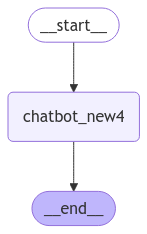

In [60]:
from IPython.display import Image, display

try:
    display(Image(graph4.get_graph().draw_mermaid_png()))
except Exception:
    print('langgraph가 만들어지지 않았습니다.')
    pass

In [62]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ['quit','exit','q']:
        print('Good bye')
        break
    else:
        for event in graph4.stream({'messages': ('user',user_input)}):
            print(event['chatbot_new4']['messages'].content)

안녕하세요! 무엇을 도와드릴까요?

저는 Google에서 훈련한 대규모 언어 모델입니다.
RTX 4090은 현재 소비자용 그래픽 카드 중 최상위 모델 중 하나로, 압도적인 성능을 자랑합니다. 주요 특징과 성능은 다음과 같습니다:

**주요 특징:**

* **아키텍처:** NVIDIA Ada Lovelace
* **CUDA 코어:** 16,384개
* **부스트 클럭:** 2.52 GHz
* **메모리:** 24GB GDDR6X
* **메모리 인터페이스:** 384-bit
* **TDP:** 450W

**성능:**

* **4K 게이밍:** 대부분의 게임에서 4K 해상도와 최고 옵션 설정으로 60fps 이상을 안정적으로 유지할 수 있습니다. 레이 트레이싱 및 DLSS 3와 같은 고급 기술을 활성화해도 높은 프레임률을 제공합니다.  특히 DLSS 3는 프레임 생성 기술을 통해 이전 세대 대비 2~4배의 성능 향상을 보여줍니다.
* **8K 게이밍:** DLSS 3와 같은 업스케일링 기술을 활용하면 8K 해상도에서도 플레이 가능한 수준의 성능을 제공합니다. 하지만 네이티브 8K 게이밍은 아직 완벽하게 지원되지 않습니다.
* **VR:** 최고 수준의 VR 경험을 제공합니다. 높은 해상도와 부드러운 프레임률로 몰입감 있는 VR 게임을 즐길 수 있습니다.
* **콘텐츠 제작:** 3D 모델링, 비디오 편집, 그래픽 디자인 등 콘텐츠 제작 작업에서도 뛰어난 성능을 발휘합니다. 복잡한 작업을 빠르게 처리하고 렌더링 시간을 단축시켜 생산성을 향상시킵니다.
* **레이 트레이싱:** 2세대 RT 코어를 탑재하여 더욱 사실적인 레이 트레이싱 효과를 제공합니다. 이전 세대보다 향상된 성능으로 더욱 몰입감 있는 게임 경험을 제공합니다.
* **DLSS 3:** 새로운 프레임 생성 기술을 통해 프레임률을 크게 향상시킵니다. 이 기술은 게임의 성능을 획기적으로 개선하여 더욱 부드럽고 쾌적한 게임 플레이를 가능하게 합니다.

**장점:**

* 최상급 게이밍 성능
* 뛰어난 레이 트

In [64]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ['quit','exit','q']:
        print('Good bye')
        break
    else:
        for event in graph4.stream({'messages': ('user',user_input)}):
            print(f"User Message : {user_input}")
            print(f"Assistant : {event['chatbot_new4']['messages'].content}")

User Message : rtx4050과 rtx4060의 게이밍 성능을 비교해 줘
Assistant : RTX 4050과 RTX 4060의 게이밍 성능 차이는 눈에 띄는 수준입니다. RTX 4060이 거의 모든 면에서 RTX 4050보다 우수한 성능을 보여줍니다.  평균적으로 RTX 4060은 RTX 4050보다 **20~30% 정도 더 빠른** 성능을 제공합니다.

다음은 두 그래픽 카드의 주요 성능 차이점을 요약한 것입니다.

* **해상도 및 프레임률:** 1080p 해상도에서 RTX 4060은 대부분의 최신 게임을 높은 설정에서 60fps 이상으로 플레이할 수 있습니다. RTX 4050은 중간 설정에서 60fps을 목표로 해야 하며, 일부 고사양 게임에서는 설정을 낮춰야 원활한 플레이가 가능합니다. 1440p 해상도에서는 RTX 4060도 설정 타협이 필요하지만, RTX 4050은 원활한 게임 플레이가 어려울 수 있습니다.

* **VRAM:** RTX 4060은 8GB의 VRAM을 탑재하고 있는 반면, RTX 4050은 6GB입니다.  최신 게임들은 점점 더 많은 VRAM을 요구하고 있기 때문에, 8GB VRAM은 미래를 위한 더 나은 투자라고 할 수 있습니다. 특히 고해상도 텍스처를 사용하거나, 고해상도에서 게임을 플레이할 경우 VRAM 용량의 차이는 더욱 두드러집니다.

* **레이 트레이싱 및 DLSS:** 두 카드 모두 레이 트레이싱과 DLSS 3를 지원하지만, 더 높은 성능의 RTX 4060이 레이 트레이싱 효과를 활성화한 상태에서도 더 높은 프레임률을 제공합니다.

* **전력 소비:** RTX 4060의 전력 소비량이 RTX 4050보다 약간 높지만, 성능 향상폭을 고려하면 효율적인 편입니다.

**결론적으로:**

* **예산이 한정되어 있고 1080p 해상도에서 중간 설정으로 게임을 플레이하는 데 만족한다면 RTX 4050을 고려할 수 있습니다.** 하지만 최신 게임을 즐기기 위해서는 설정 타협이 필요할 수 있으며, 향후 게임들의 요

### MessageState를 상속받아 state 만들기

In [65]:
from typing_extensions import TypedDict 
#typing이나 typing_extensions나 동일하게 동작하나 langgraph 공식 문서에서는 typing_extensions에서 갖고 온다
from typing import Annotated

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
import operator

from langchain_google_genai import ChatGoogleGenerativeAI

from dotenv import load_dotenv
import os

In [67]:
# .env 파일 로드(api key load)
load_dotenv()

True

In [68]:
#langsmith Setting
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com" 
os.environ["LANGCHAIN_PROJECT"] = "langsmith_basic"                 #표시될 PJT명 Setting
#os.environ["LANGCHAIN_API_KEY"] = "lsv2_***"                        *.env로 setting
from langsmith import Client
client = Client()

In [119]:
#add_messages의 메타 data를 갖는 list 형태의 message dict인 State를 MessagesState로 정의된 lib 사용

class State5(MessagesState):  #MeassageState를 상속받기(그대로 활용용)
    counter: int              #counter 인자는 int 속성

graph_builder5 = StateGraph(State5)

In [109]:
llm = ChatGoogleGenerativeAI(model='gemini-1.5-pro', temperature= 0)

In [120]:
def chatbot5(state: State5):                             #State5를 입력받아 내부 변수인 state로 만든다.
    state['counter'] = 1
    state["messages"] = llm.invoke(state['messages'])
    return state

In [121]:
graph_builder5.add_node('chatbot_new5', chatbot5) # chatbot_new 이름의 노드를 만들고 노드 함수는 chatbot 사용

graph_builder5.set_entry_point('chatbot_new5') #graph에서 start지점 설정하기
graph_builder5.set_finish_point('chatbot_new5') #graph에서 finish지점 설정하기기

In [122]:
graph5 = graph_builder5.compile() #graph5로 compilie하기

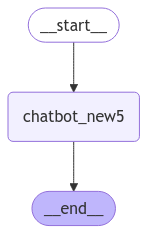

In [123]:
from IPython.display import Image, display

try:
    display(Image(graph5.get_graph().draw_mermaid_png()))
except Exception:
    print('langgraph가 만들어지지 않았습니다.')
    pass

In [125]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ['quit','exit','q']:
        print('Good bye')
        break
    else:
        for event in graph5.stream({'messages': ('user',user_input)}):
            print(f"counter : {event['chatbot_new5']['counter']}")
            print(f"User Message : {user_input}")
            print(f"Assistant : {event['chatbot_new5']['messages'].content}")

counter : 1
User Message : 삼성 노트북 라인업에 대해서 알려줘
Assistant : 삼성 노트북 라인업은 크게 **갤럭시 북**, **비스포크**, 그리고 **크롬북** 시리즈로 나뉘며, 각 시리즈는 사용 목적과 가격대에 따라 다양한 모델을 제공합니다. 주요 특징과 차이점을 정리하면 다음과 같습니다.

**1. 갤럭시 북 시리즈:**

* **프리미엄 라인업:** 삼성의 주력 노트북 시리즈로, 고성능과 세련된 디자인을 특징으로 합니다. 갤럭시 생태계와의 연동성이 뛰어나 스마트폰, 태블릿 등과의 연결성이 강조됩니다.
* **다양한 모델:** 갤럭시 북3 프로, 갤럭시 북3 프로 360, 갤럭시 북3 울트라, 갤럭시 북3, 갤럭시 북2 프로, 갤럭시 북2 프로 360, 갤럭시 북2 360, 갤럭시 북 Go 등 다양한 모델이 있으며, 성능, 휴대성, 폼팩터(일반 노트북, 2-in-1) 등에서 차이가 있습니다.
* **주요 특징:** AMOLED 디스플레이, S펜 지원 (일부 모델), 가벼운 무게, 고성능 프로세서, 넉넉한 저장 용량 등을 제공합니다.
* **대상 사용자:** 고성능 작업, 콘텐츠 제작, 엔터테인먼트, 휴대성을 중시하는 사용자에게 적합합니다.

**2. 비스포크 인피니티 원:**

* **맞춤형 디자인:** 비스포크 라인업의 철학을 계승하여 사용자의 취향에 맞게 색상을 선택할 수 있습니다.
* **프리미엄 성능:** 갤럭시 북 시리즈와 마찬가지로 고성능 부품과 뛰어난 디스플레이를 탑재했습니다.
* **13세대 인텔 코어 프로세서:** 최신 프로세서를 탑재하여 빠른 속도와 높은 생산성을 제공합니다.
* **대상 사용자:** 개성을 중시하고 고성능 노트북을 원하는 사용자에게 적합합니다.

**3. 크롬북 시리즈:**

* **가성비 라인업:** 크롬 OS를 기반으로 하여 가볍고 빠른 부팅 속도와 저렴한 가격이 장점입니다.
* **클라우드 기반:** 구글 계정을 통해 데이터를 저장하고 관리하며, 웹 기반 애플리케이션을 주로 사용합니다.